# Import libs

In [1]:
import pandas as pd
import numpy as np 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import sys

sys.path.append('..')
from eflow.ClusterMaster import *
from eflow.DataFrameTypes import *
from eflow.PipelineSegments.DataCleaner import *
from xgboost import XGBClassifier
import ipython_blocking
from pivottablejs import pivot_ui
import scikitplot as skplt

ModuleNotFoundError: No module named 'eflow.PipelineSegments'

In [ ]:
from eflow.analysis_objects.data_analysis import *

In [1]:
import sys
import pandas as pd
sys.path.append('..')
from eflow.analysis_objects import DataAnalysis
# from eflow.analysis_objects import DataAnalysis
DataAnalysis

eflow.analysis_objects.data_analysis.DataAnalysis

In [2]:
%matplotlib notebook
%matplotlib inline

### Be sure to run the following

## Declare Worflow Variables

#### (This should be the only place you should have to declare anything)

In [3]:
dataset_path = "Datasets/titanic_train.csv"
target_column = "Survived"
parent_project_name = "Pre processing"
prediction_method = "Classification"
notebook_mode = True

# Import dataset

In [4]:
df = pd.read_csv(dataset_path)
display(df.shape)
df.head()

NameError: name 'pd' is not defined

## Interaction tool for dataframes

### Explore the data

In [5]:
pivot_ui(df,
         outfile_path='Piviot_Table_JS.html')

In [6]:
# w = widgets.SelectMultiple(
#     options=['Apples', 'Oranges', 'Pears'],
#     value=['Oranges'],
#     #rows=10,
#     description='Fruits',
#     disabled=False
# )
# del w

In [7]:
a = str(u"\u2192")
print(a)

→


## Remove Un-Wanted Columns

### Do not remove nans yet, let the datacleaner do it's job

In [8]:
df.drop(columns=["Name",
                 "Ticket",
                 "PassengerId"],
        inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


In [9]:
from dateutil import parser
dt = parser.parse("Aug 28 1999 12:00AM")

In [10]:
df["Date_test"] = ["2019-01-02" for _ in range(0,df.shape[0])]
df["Date_test"][0] = np.nan
# df["Date_test"] = [parser.parse(val)for val in df["Date_test"].value_counts().keys()]

/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Basic Feature manipulation

### Change cabin column to have the level on the ship

In [11]:
df["Cabin"] = df["Cabin"].str.replace(r'\d+', '').str[0]

## Change Feature Data types

### Look at data types

In [12]:
df.dtypes

Survived       int64
Pclass         int64
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Cabin         object
Embarked      object
Date_test     object
dtype: object

### Make given data type changes

In [13]:
# df["Pclass"] = df["Pclass"].replace(1, np.nan)

### Final look at data types

In [14]:
df.dtypes

Survived       int64
Pclass         int64
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Cabin         object
Embarked      object
Date_test     object
dtype: object

## Set up DataFrameTypes

In [15]:
df_features = DataFrameTypes(df,
                             target_column=target_column,
                             ignore_nulls=True)

Categorical Features: {'Cabin', 'Embarked', 'Sex'}

Possible One hot encoded feature names: {'Cabin': ['Cabin_E', 'Cabin_D', 'Cabin_F', 'Cabin_B', 'Cabin_T', 'Cabin_A', 'Cabin_C', 'Cabin_G'], 'Embarked': ['Embarked_S', 'Embarked_Q', 'Embarked_C'], 'Sex': ['Sex_male', 'Sex_female']}

------------------------------------------------------------------------------------------
Numerical Features: {'Survived', 'Parch', 'SibSp', 'Age', 'Fare', 'Pclass'}

Integer Features: {'Parch', 'SibSp', 'Pclass', 'Survived'}

Float Features: {'Age', 'Fare'}

Datetime Features: {'Date_test'}

Target Feature: Survived



## Skim through Value Counts

In [16]:
for col in df.columns:
    if col not in df_features.get_float_features() and len(np.unique(df[col].dropna().values)) <= 12:
        display(df[col].value_counts())
        print("***" * 4 + "\n\n")

0    549
1    342
Name: Survived, dtype: int64

************




3    491
1    216
2    184
Name: Pclass, dtype: int64

************




male      577
female    314
Name: Sex, dtype: int64

************




0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

************




0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

************




C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

************




S    644
C    168
Q     77
Name: Embarked, dtype: int64

************




2019-01-02    890
Name: Date_test, dtype: int64

************




### Perform quick analysis

In [2]:
analysis_obj = DataAnalysis(df,
                            df_features,
                            project_name=f'{parent_project_name}/General Analysis (Before Cleaning)',
                            missing_data_visuals=False)

NameError: name 'df' is not defined

## Data Cleaning

Your selected dataframe has 10 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Date_test,1,0.1


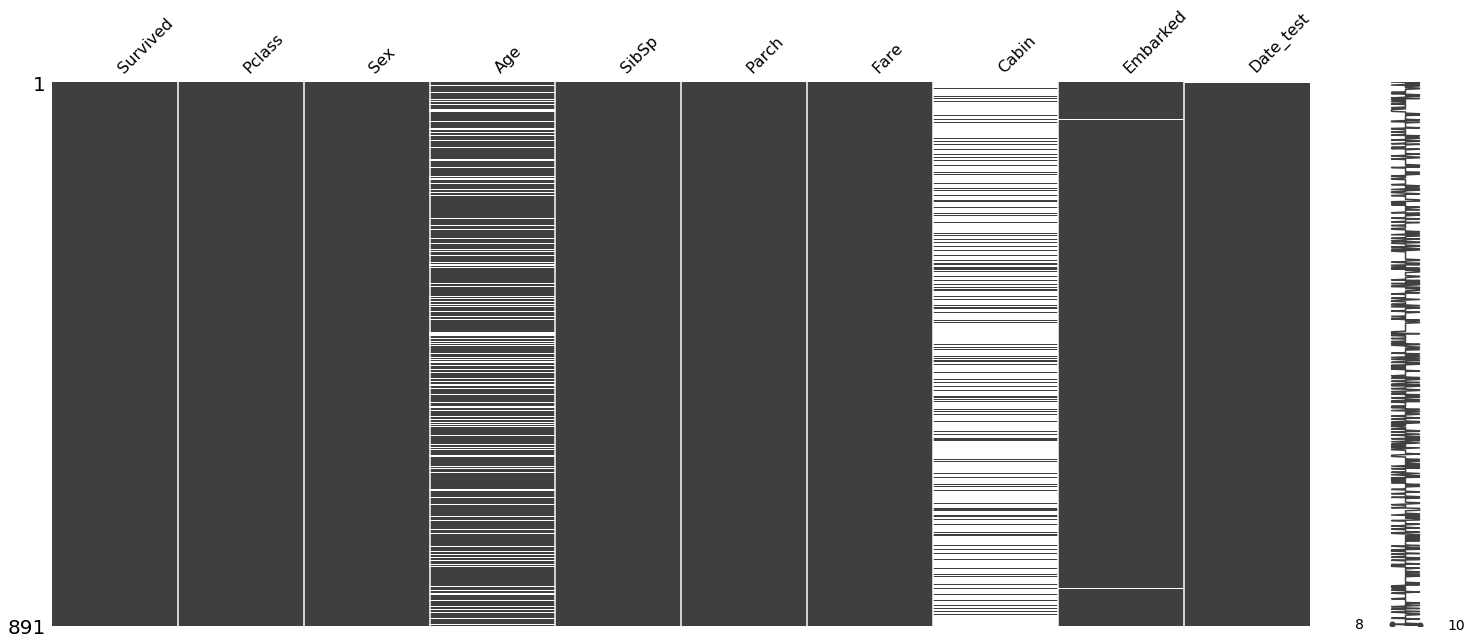

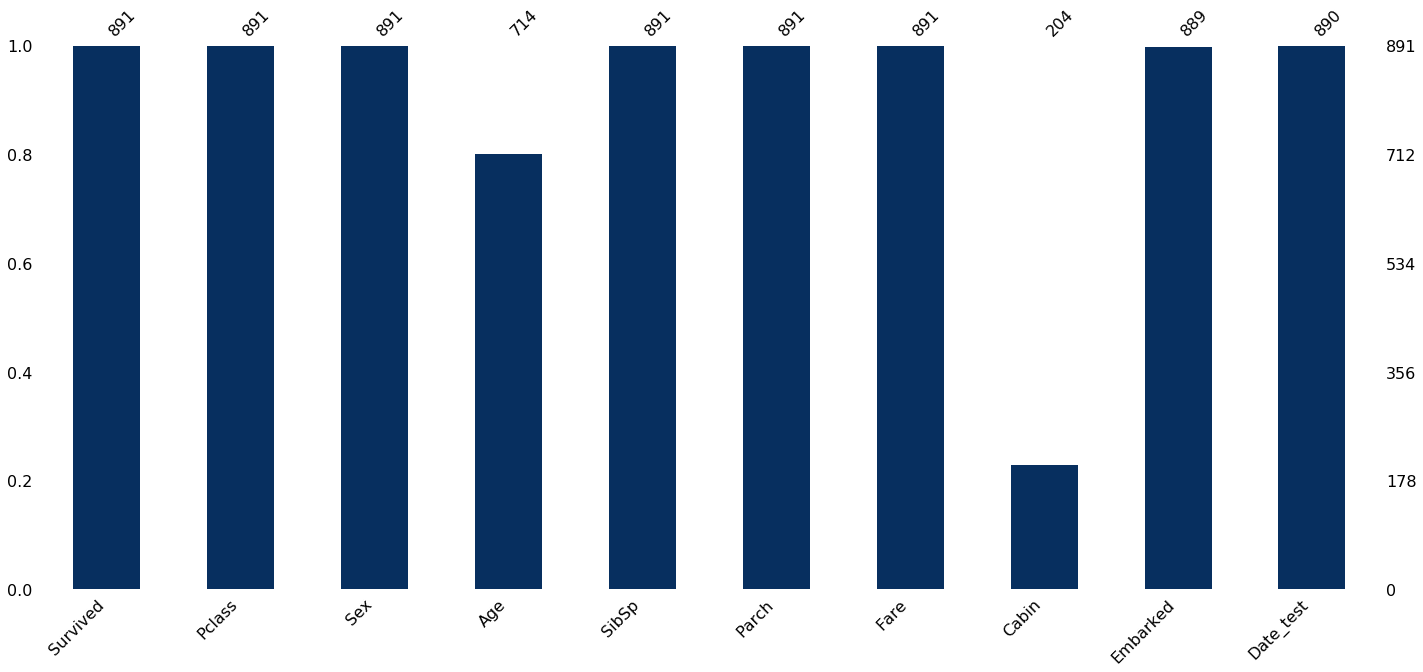

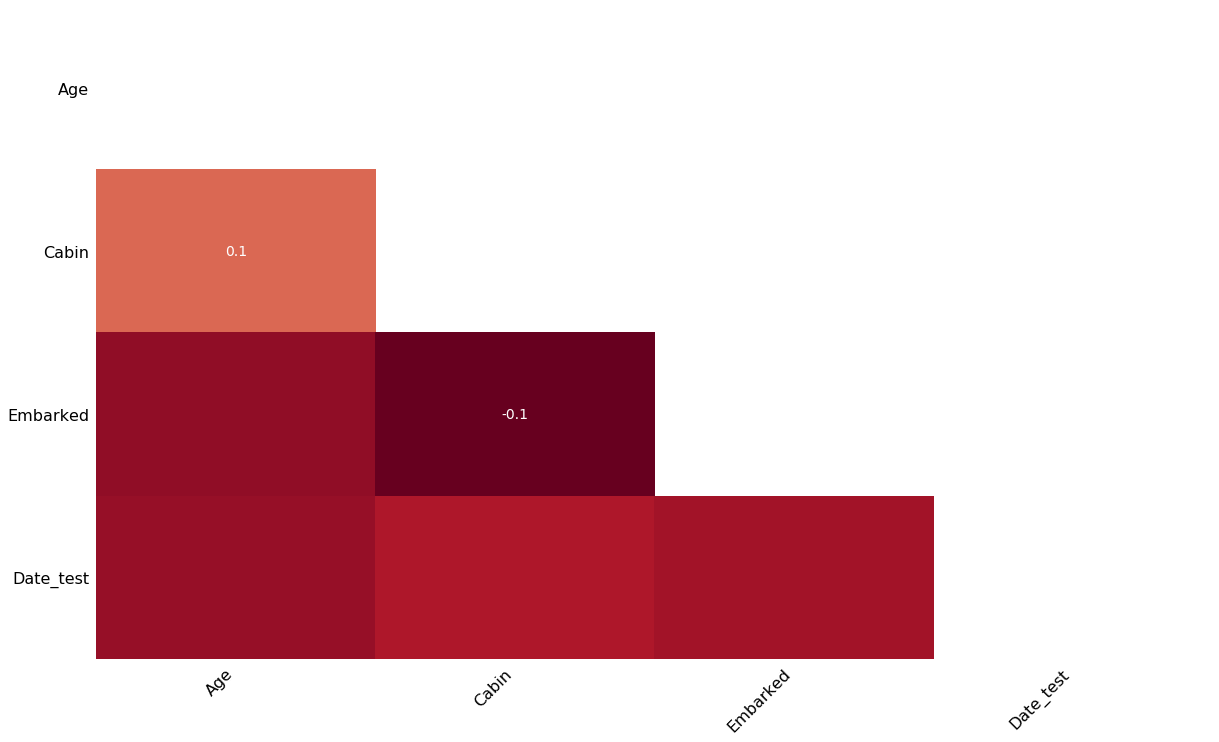

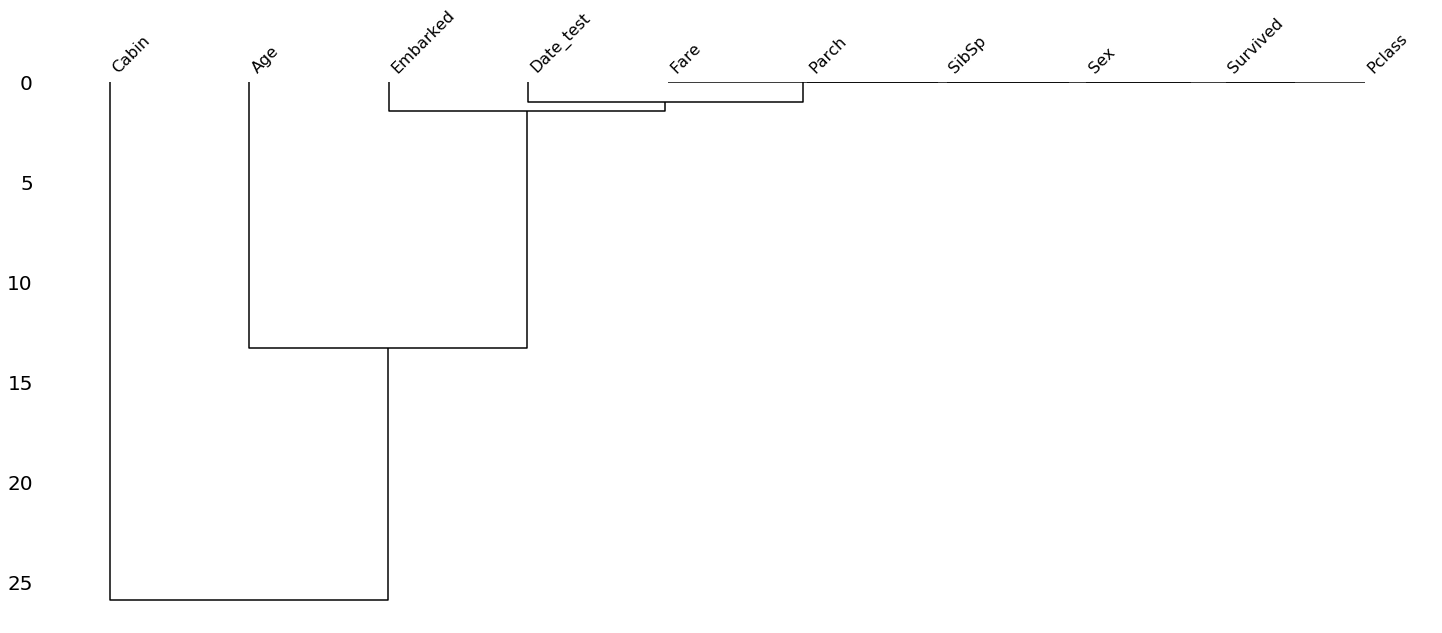

In [18]:
data_cleaner = DataCleaner(df,
                           project_name=f'{parent_project_name}/Data Cleaning',
                           missing_data_visuals=True)

In [19]:
data_cleaner.data_cleaning_widget(df,
                                  df_features)

Text(value='Default Data Cleaning', description='File Name:', layout=Layout(left='590px'), placeholder='Replac…

interactive(children=(Select(description='Features', layout=Layout(height='175px', width='50%'), options=('Age…

Button(description='Create JSON File from options', layout=Layout(bottom='5px', left='100px', width='40%'), st…

In [20]:
data_cleaner.get_last_saved_json_file_path()

AttributeError: 'DataCleaner' object has no attribute 'get_last_saved_json_file_path'

In [ ]:
data_cleaner.data_cleaning_with_json_file(df,
                                          data_cleaner.get_last_saved_json_file_path())

In [ ]:
from impyute.imputation.cs import mice

a = df["Age"].tolist()
# start the MICE training
imputed_training=mice(df.values)

In [ ]:
import datawig

df_train, df_test = datawig.utils.random_split(df)

#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin','Embarked'], # column(s) containing information about the column we want to impute
    output_column= 'Age', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )

#Fit an imputer model on the train data
imputer.fit(train_df=df, num_epochs=200)

In [ ]:
imputed_training=mice(df[df_features.get_numerical_features()].values)

In [ ]:
# !pip install datawig
# !pip install opencv-python
# !pip install Pillow
# !pip install tesserocr

In [23]:
import random

df["Cabin"] = df["Cabin"].fillna("A")
test = df.drop(columns=["Date_test", "Embarked"]).dropna()

test["Cabin"] = df["Cabin"] == "B"
test["Sex"] = df["Sex"] == "male"
test[target_column] = [random.randint(0, 5) for _ in range(0,test.shape[0])]
print(len(test[target_column]))

y = test[target_column].values
X = test.values

print(X.shape)
print(y.shape)


df_features = DataFrameTypes(test,
                             target_column=target_column,
                             ignore_nulls=True) 
df_features.get_all_features()

714
(714, 8)
(714,)
Bool Features: {'Cabin', 'Sex'}

------------------------------------------------------------------------------------------
Numerical Features: {'Survived', 'Parch', 'SibSp', 'Age', 'Fare', 'Pclass'}

Integer Features: {'Parch', 'SibSp', 'Pclass', 'Survived'}

Float Features: {'Age', 'Fare'}

Target Feature: Survived



['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=517, stratify=y,
)

In [25]:
from sklearn.tree import DecisionTreeClassifier
from eFlow.ToolBox.Modeling import *
# Find best parameters for model
param_grid = {
    "max_depth": list(range(2, 3)),
    "min_samples_leaf": list(range(80, 130, 5)),
    "criterion": ["gini", "entropy"],
#     "n_splits": [20, 30]
}

model, best_params = optimize_model_grid(
    model=DecisionTreeClassifier(),
    X_train=X_train, y_train=y_train,
    param_grid=param_grid
)

Tuned Parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 80}
Best score on trained data was 0.687850


/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


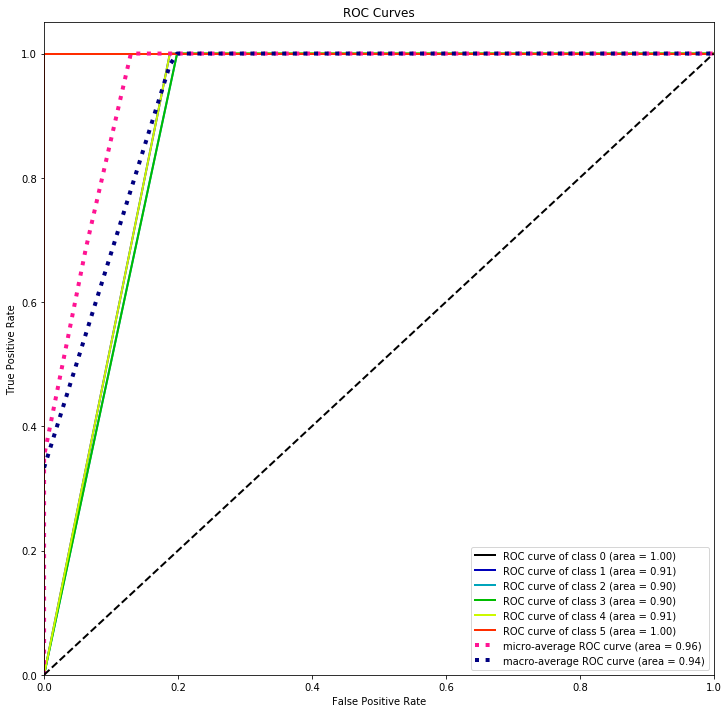

In [26]:
skplt.metrics.plot_roc(y_test, model.predict_proba(X_test),
                      figsize=(12,12))

In [29]:
from eFlow._Hidden.Objects.enum import enum
from eFlow.Utils.SysUtils import create_plt_png, convert_to_filename, df_to_image, write_object_text_to_file, get_unique_directory_path, pickle_object_to_file
from eFlow._Hidden.Objects.FileOutput import *
from eFlow._Hidden.CustomExc import *
from eFlow.Analysis.DataAnalysis import *

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
import scikitplot as skplt
import numpy as np
import warnings
import copy
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

class ClassificationAnalysis(FileOutput):

    def __init__(self,
                 model,
                 model_name,
                 pred_funcs_dict,
                 project_name="Classification Analysis",
                 overwrite_full_path=None,
                 notebook_mode=True,
                 target_classes=None,
                 df_features=None,
                 columns=[],
                 save_model=True):
        """
        model:
            A fitted supervised machine learning model.

        model_name:
            The name of the model in string form.
        
        pred_funcs_dict:
            A dict of the name of the function and the function defintion for the 
            model prediction methods.
            (Can handle either a return of probabilities or a singile value.)
            
            Init Example:
            pred_funcs = dict()
            pred_funcs["Predictions"] = model.predict
            pred_funcs["Probabilities"] = model.probas

        project_name:
            Creates a parent or "project" folder in which all sub-directories
            will be inner nested.

        overwrite_full_path:
            Overwrites the path to the parent folder.

        notebook_mode:
            If in a python notebook display in the notebook.
            
        target_classes:
            Specfied list/np.array of targeted classes the model predicts. If set to 
            none then it will attempt to pull from the sklearn's default attribute 
            '.classes_'.
        
        df_features:
            DataFrameTypeHolder object. If initalized we can run correct/error 
            analysis on the dataframe. Will save object in a pickle file and provided columns 
            if initalized and df_features is not initalized.
            
        columns:
            Will overwrite over df_features (DataFrameTypeHolder) regardless of wether 

        Returns/Desc:
            Evaluates the given model based on the prediction functions pased to it.
            Saves the model and other various graphs/dataframes for evaluation.
        """

        # Init any parent objects
        FileOutput.__init__(self,
                            f'{project_name}/{model_name}',
                            overwrite_full_path)

        # Init objects without pass by refrence
        self.__model = copy.deepcopy(model)
        self.__model_name = copy.deepcopy(model_name)
        self.__notebook_mode = copy.deepcopy(notebook_mode)
        self.__target_values = copy.deepcopy(target_classes)
        self.__df_features = copy.deepcopy(df_features)
        self.__pred_funcs_dict = copy.deepcopy(pred_funcs_dict)
        self.__pred_funcs_types = dict()
        
        # Init on sklearns default target classes attribute
        if not self.__target_values:
            self.__target_values = copy.deepcopy(model.classes_)
        # ---
        if len(self.__target_values) != 2:
            self.__binary_classifcation = False
        else:
            self.__binary_classifcation = True
            
        # Save machine learning model
        if save_model:
            pickle_object_to_file(self.__model,
                                  self.get_output_folder(),
                                  f'{self.__model_name}')

        # ---
        check_create_dir_structure(self.get_output_folder(),
                                   "Extras")
        # Save predicted classes
        write_object_text_to_file(self.__target_values,
                                  self.get_output_folder() + "Extras",
                                  "_Classes")
        
        # Save features and or df_features object
        if columns or df_features:
            if columns:
                write_object_text_to_file(columns,
                                          self.get_output_folder() + "Extras",
                                          "_Features")
            else:
                write_object_text_to_file(df_features.get_all_features(),
                                          self.get_output_folder() + "Extras",
                                          "_Features")
                pickle_object_to_file(self.__model,
                              self.get_output_folder() + "Extras",
                              "_df_features")
                
        # Find the 'type' of each prediction. Probabilities or Predictions
        if self.__pred_funcs_dict:
            for pred_name, pred_func in self.__pred_funcs_dict.items():
                model_output = pred_func(
                    np.reshape(X_train[0],
                               (-1, X_train.shape[1])))[0]

                # Confidence / Probability (Continuous output)
                if isinstance(model_output, list) or isinstance(model_output,
                                                                np.ndarray):
                    self.__pred_funcs_types[pred_name] = "Probabilities" 

                # Classification (Discrete output)
                else:
                    self.__pred_funcs_types[pred_name] = "Predictions"
        else:
            raise RequiresPredictionMethods

    def __get_model_prediction(self,
                               pred_name,
                               X,
                               thresholds=None):
        """
        X:
            Feature matrix.
            
        pred_name:
            The name of the prediction function in questioned stored in 'self.__pred_funcs_dict'

        thresholds:
            If the model outputs a probability list/numpy array then we apply
            thresholds to the ouput of the model.

        Returns/Desc:
            Returns back a predicted value based for a given matrix. 
            Handles prediction function 'types' Predictions and Probabilities.
            Helps streamline the entire process of evaluating classes.
        """
        
        # Must be a prediction function
        if self.__pred_funcs_types[pred_name] == "Predictions":
            return self.__pred_funcs_dict[pred_name](X)
        
        elif self.__pred_funcs_types[pred_name] == "Probabilities":    
            model_output = self.__get_model_probas(pred_name,
                                                   X,
                                                   thresholds)

            return np.asarray([self.__target_values[np.argmax(proba)]
                               for proba in model_output])
        else:
            raise UnknownModelOutputType

    def __get_model_probas(self,
                           pred_name,
                           X,
                           thresholds=None):
        """
        X:
            Feature matrix.
            
        pred_name:
            The name of the prediction function in questioned stored in 'self.__pred_funcs_dict'

        thresholds:
            If the model outputs a probability list/numpy array then we apply
            thresholds to the ouput of the model.

        Returns/Desc:
            Returns back a series of values between 0-1 to represent it's confidence.
            Invokes an error if the prediction function call is anything but a Probabilities
            call.
        """
        
        if self.__pred_funcs_types[pred_name] == "Probabilities":
            model_output = self.__pred_funcs_dict[pred_name](X)
            
            # Validate probabilities
            if thresholds:
                if isinstance(thresholds, list) or \
                        isinstance(thresholds, np.ndarray):
                    if sum(thresholds) != 1:
                        print("Thresholds didn't add up to 100%! "
                              "This may cause issues in your results!")
                    if len(thresholds) != len(self.__target_values):
                        raise ThresholdLength
                else:
                    raise ThresholdType
            
            # ---
            if isinstance(model_output, list):
                model_output = np.asarray(model_output)

            if isinstance(model_output, np.ndarray):
                if thresholds:
                    model_output = model_output - np.asarray(thresholds)
            
            return model_output
        else:
            raise ProbasNotPossible

    def __create_sub_dir_with_thresholds(self,
                                         pred_name,
                                         dataset_name,
                                         thresholds):
        """
        pred_name:
            The prediction function's name.

        dataset_name:
            The passed in dataset's name.

        thresholds:
            If the model outputs a probability list/numpy array then we apply
            thresholds to the ouput of the model.
            
        Returns/Desc:
            Looking at the root of the starting directory and looking at each
            '_Thresholds.txt' file to determine if the files can be outputed
            to that directory. The content of the file must match the content
            of the list/numpy array 'thresholds'.
        """
        sub_dir = f'{dataset_name}/{pred_name}'
        
        # Only generate extra folder structure if function type is Probabilities
        if self.__pred_funcs_types[pred_name] == "Probabilities":
            
            # ------
            if not thresholds:
                sub_dir = f'{sub_dir}/No Thresholds'
            else:
                i = 0
                sub_dir = f'{sub_dir}/Thresholds'
                tmp_sub_dir = copy.deepcopy(sub_dir)
                while True:
                    threshold_dir = self.get_output_folder()
                    if i > 0:
                        tmp_sub_dir = (sub_dir + f' {i}')
                    threshold_dir += tmp_sub_dir
                    
                    # If file exists with the same thresholds; than use this directory
                    if os.path.exists(threshold_dir):
                        if self.__compare_thresholds_to_saved_thresholds(threshold_dir,
                                                                         thresholds):
                            sub_dir = tmp_sub_dir
                            break
                    
                    # Create new directory
                    else:
                        os.makedirs(threshold_dir)
                        write_object_text_to_file(thresholds,
                                                  threshold_dir,
                                                  "_Thresholds")
                        sub_dir = tmp_sub_dir
                        break
                    
                    # Iterate for directory name change
                    i += 1

        return sub_dir
    
    def __compare_thresholds_to_saved_thresholds(self,
                                                 directory_pth,
                                                 thresholds):
        """
        directory_pth:
            Path to the given folder where the "_Thresholds.txt"

        thresholds:
            If the model outputs a probability list/numpy array then we apply
            thresholds to the ouput of the model.

        Returns/Desc:
            Compare the thresholds object to the text file; returns true if 
            the file exists and the object's value matches up.
        """

        file_directory = correct_directory_path(directory_pth)
        
        if os.path.exists(file_directory):
            
            # Extract file contents and convert to a list object
            file = open(file_directory + "_Thresholds.txt", "r") 
            line = file.read()
            converted_list = line.split("=")[-1].strip().strip('][').split(', ')
            converted_list = [float(val) for val in converted_list]
            file.close()

            if thresholds == converted_list:
                return True
            else:
                return False
        else:
            return False

    def peform_analysis(self,
                        X,
                        y,
                        dataset_name,
                        thresholds_matrix=None,
                        normalize_confusion_matrix=True,
                        ignore_metrics=[],
                        custom_metrics=dict(),
                        average_scoring=["micro",
                                         "macro",
                                         "weighted"],
                        display_analysis_graphs=False):
        """
        X/y:
            Feature matrix/Target data vector.

        dataset_name:
            The dataset's name.
            
        thresholds_matrix:
            Lists of list objects containing thresholds to iterate through
            for a model functon that is of type "Probabilities". 
            
        normalize_confusion_matrix:
            Normalize the confusion matrix buckets.

        ignore_metrics:
            Specify set metrics to ignore. (F1-Score, Accuracy etc).

        ignore_metrics:
            Specify the default metrics to not apply to the classification
            analysis.
                * Precision
                * MCC
                * Recall
                * F1-Score
                * Accuracy
        
        custom_metrics:
            Pass the name of metric(s) and the function definition(s) in a
            dictionary.

        average_scoring:
            Determines the type of averaging performed on the data.
            
        display_analysis_graphs:
            Controls visual display of error error analysis if it is able to run.

        Returns/Desc:
            Performs all classification functionality with the provided feature
            data and target data.
                * plot_precision_recall_curve
                * classification_evaluation
                * plot_confusion_matrix
        """
        if isinstance(thresholds_matrix,np.ndarray):
            thresholds_matrix = thresholds_matrix.tolist()
        
        if not thresholds_matrix:
            thresholds_matrix = list()

        if isinstance(thresholds_matrix,list) and not isinstance(thresholds_matrix[0],list):
            thresholds_matrix = list(thresholds_matrix)

        thresholds_matrix.append(None)
            
        print("\n\n" + "---" * 10 + f'{dataset_name}' + "---" * 10)

        for pred_name, pred_type in self.__pred_funcs_types.items():
            print(f"Now running classification on {pred_name}")
            
            for thresholds in thresholds_matrix:
                if pred_type == "Predictions":
                    thresholds = None

                self.classification_metrics(X,
                                            y,
                                            pred_name=pred_name,
                                            dataset_name=dataset_name,
                                            thresholds=thresholds,
                                            ignore_metrics=ignore_metrics,
                                            custom_metrics=custom_metrics,
                                            average_scoring=average_scoring)
    
                self.plot_confusion_matrix(X,
                                           y,
                                           pred_name=pred_name,
                                           dataset_name=dataset_name,
                                           title=tmp_filename,
                                           thresholds=thresholds,
                                           normalize=normalize_confusion_matrix)

                self.plot_classification_error_analysis(X,
                                                        y,
                                                        pred_name=pred_name,
                                                        dataset_name=dataset_name,
                                                        thresholds=thresholds)
                
                if pred_type == "Probabilities":
                    self.plot_precision_recall_curve(X,
                                                     y,
                                                     sub_dir=sub_dir,
                                                     title=tmp_filename,
                                                     filename=tmp_filename,
                                                     thresholds=thresholds)
                if self.__df_features:
                    self.classification_error_analysis(X,
                                                       y,
                                                       pred_name=pred_name,
                                                       dataset_name=dataset_name,
                                                       thresholds=thresholds,
                                                       display_graphs=display_graphs)


                
                    if pred_type == "Predictions":
                        break


#     def plot_precision_recall_curve(self,
#                                     X,
#                                     y,
#                                     pred_name,
#                                     dataset_name,
#                                     thresholds=None,
#                                     sub_dir="",
#                                     figsize=(10, 8),
#                                     title=None,
#                                     filename=None):
#         """
#         X/y:
#             Feature matrix/Target data vector.

#         sub_dir:
#             Specify a subdirectory to append to the output path of the file.

#         figsize:
#             Plot's size.

#         title:
#             Title of the plot.

#         filename:
#             Name of the file. If set to 'None' then don't create the file.

#         Returns/Desc:

#         """
#         if title:
#             skplt.metrics.plot_precision_recall(self.get_model_probas(X),
#                                                 y,
#                                                 figsize=figsize,
#                                                 title=title)
#         else:
#             skplt.metrics.plot_precision_recall(self.get_model_probas(X),
#                                                 y,
#                                                 figsize=figsize)

#         if filename:
#             create_plt_png(self.get_output_folder(),
#                            sub_dir,
#                            convert_to_filename(filename))

#         if self.__notebook_mode:
#             plt.show()
#         plt.close()

    def plot_confusion_matrix(self,
                              X,
                              y,
                              pred_name,
                              dataset_name,
                              thresholds=None,
                              figsize=(10, 8),
                              title=None,
                              normalize=True):
        """
        X/y:
            Feature matrix/Target data vector.
            
        pred_name:
            
        dataset_name:
            The dataset's name.
        thresholds:
            
        figsize:
            
        title:
        
        normalize:
        
        Returns/Descr:
            
        """
        
        filename = f'Confusion Matrix: {dataset_name} on {self.__model_name}'
        sub_dir = self.__create_sub_dir_with_thresholds(pred_name,
                                                        dataset_name,
                                                        thresholds)

        warnings.filterwarnings('ignore')
        if title:
            skplt.metrics.plot_confusion_matrix(self.__get_model_prediction(pred_name,
                                                                            X,
                                                                            thresholds),
                                                y,
                                                figsize=figsize,
                                                title=title,
                                                normalize=normalize,)
        else:
            skplt.metrics.plot_confusion_matrix(self.__get_model_prediction(pred_name,
                                                                            X,
                                                                            thresholds),
                                                y,
                                                figsize=figsize,
                                                normalize=normalize)
        warnings.filterwarnings('default')

        create_plt_png(self.get_output_folder(),
                       sub_dir,
                       convert_to_filename(filename))

        if self.__notebook_mode:
            plt.show()
        plt.close()

    def classification_metrics(self,
                               X,
                               y,
                               pred_name,
                               dataset_name,
                               thresholds=None,
                               title="",
                               sub_dir="",
                               filename=None,
                               custom_metrics=dict(),
                               ignore_metrics=[],
                               average_scoring=["micro",
                                                "macro",
                                                "weighted"]):
        """
        X/y:
            Feature matrix/Target data vector.

        title:
            Adds to the column 'Metric Score'.

        sub_dir:
            Specify a subdirectory to append to the output path of the file.

        custom_metrics:
            Pass the name of metric(s) and the function definition(s) in a
            dictionary.

        ignore_metrics:
            Specify the default metrics to not apply to the classification
            analysis.
                * Precision
                * MCC
                * Recall
                * F1-Score
                * Accuracy

        average_scoring:
            Determines the type of averaging performed on the data.
                * micro
                * macro
                * weighted

        Returns/Desc:
            Creates/displays a dataframe object based on the model's
            predictions on the feature matrix compared to target data.
        """
        filename = f'Metric Evaluation on {dataset_name} on {self.__model_name}'
        sub_dir = self.__create_sub_dir_with_thresholds(pred_name,
                                                        dataset_name,
                                                        thresholds)
        
        if not isinstance(average_scoring, list):
            average_scoring = [average_scoring]

        # Default metric name's and their function
        metric_functions = dict()
        metric_functions["Precision"] = precision_score
        metric_functions["MCC"] = matthews_corrcoef
        metric_functions["Recall"] = recall_score
        metric_functions["F1-Score"] = f1_score
        metric_functions["Accuracy"] = accuracy_score

        warnings.filterwarnings('ignore')

        # Ignore default metrics if needed
        for remove_metric in ignore_metrics:
            if remove_metric in metric_functions:
                del metric_functions[remove_metric]

        # Add in custom metrics
        if len(custom_metrics.keys()):
            metric_functions.update(custom_metrics)

        # Evaluate model on metrics
        evaluation_report = dict()
        for metric_name in metric_functions:
            for average_score in average_scoring:

                model_predictions = self.__get_model_prediction(pred_name,
                                                                X,
                                                                thresholds)
                try:
                    evaluation_report[f'{metric_name}({average_score})'] = \
                    metric_functions[metric_name](y_true=y,
                                                  y_pred=model_predictions,
                                                  average=average_score)
                except TypeError:
                    evaluation_report[metric_name] = metric_functions[
                        metric_name](y,
                                     model_predictions)
                    break

                except ValueError:
                    pass

        warnings.filterwarnings('default')

        if len(title) > 0:
            index_name = f"Metric Scores ({title})"
        else:
            index_name = "Metric Scores"

        # ---
        evaluation_report = pd.DataFrame({index_name:
                                              [f'{metric_score:.4f}'
                                               for metric_score
                                               in evaluation_report.values()]},
                                         index=list(evaluation_report.keys()))

        if self.__notebook_mode:
            display(evaluation_report)
        else:
            print(evaluation_report)

        # Create image file
        df_to_image(evaluation_report,
                    self.get_output_folder(),
                    sub_dir,
                    convert_to_filename(filename),
                    col_width=20,
                    show_index=True,
                    format_float_pos=4)


    def plot_classification_error_analysis(self,
                                           X,
                                           y,
                                           pred_name,
                                           dataset_name,
                                           thresholds=None,
                                           display_graphs=False):
        
        sub_dir = self.__create_sub_dir_with_thresholds(pred_name,
                                                        dataset_name,
                                                        thresholds)

        model_predictions = self.__get_model_prediction(pred_name,
                                                        X,
                                                        thresholds=thresholds)

        if display_graphs:
            print("\n\n" + "*" * 10 +
                  "Correctly predicted analysis"
                  + "*" * 10 + "\n")
        else:
            print("\n\n" + "*" * 10 +
                  "Generating graphs for model's correctly predicted..." +
                  "*" * 10 + "\n")
        DataAnalysis(pd.DataFrame(X[model_predictions == y],
                     columns=self.__df_features.get_all_features()),
                     self.__df_features,
                     overwrite_full_path=self.get_output_folder() +
                                         sub_dir + "/Correctly Predicted Data/",
                     missing_data_visuals=False,
                     notebook_mode=display_graphs)


        if display_graphs:
            print("\n\n" + "*" * 10 +
                  "Incorrectly predicted analysis"
                  + "*" * 10 + "\n")
        else:
            print("\n\n" + "*" * 10 +
                  "Generating graphs for model's incorrectly predicted..." +
                  "*" * 10 + "\n")

        DataAnalysis(pd.DataFrame(X[model_predictions != y],
                     columns=self.__df_features.get_all_features()),
                     self.__df_features,
                     overwrite_full_path=self.get_output_folder() +
                                         sub_dir + "/Incorrectly Predicted Data/",
                     missing_data_visuals=False,
                     notebook_mode=display_graphs)

    def classification_report(self,
                              X,
                              y,
                              pred_name,
                              dataset_name,
                              thresholds=None):
        """
        X/y:
        
        pred_name:
        
        dataset_name:
        
        thresholds:
        """
        filename = f'Classification Report {dataset_name} on {self.__model_name}'
        sub_dir = self.__create_sub_dir_with_thresholds(pred_name,
                                                        dataset_name,
                                                        thresholds)
        
        report_df = pd.DataFrame(classification_report(y,
                                                       self.__get_model_prediction(pred_name,
                                                                                   X,
                                                                                   thresholds),
                                                       output_dict=True))

        if self.__notebook_mode:
            display(report_df)
        else:
            print(report_df)

        df_to_image(report_df,
                    self.get_output_folder(),
                    sub_dir,
                    filename,
                    col_width=20,
                    show_index=True,
                    format_float_pos=4)



------------------------------Training Data------------------------------
Now running classification on Probabilities function
Thresholds didn't add up to 100%! This may cause issues in your results!
Thresholds didn't add up to 100%! This may cause issues in your results!
Thresholds didn't add up to 100%! This may cause issues in your results!
Thresholds didn't add up to 100%! This may cause issues in your results!
Thresholds didn't add up to 100%! This may cause issues in your results!
Thresholds didn't add up to 100%! This may cause issues in your results!
Thresholds didn't add up to 100%! This may cause issues in your results!
Thresholds didn't add up to 100%! This may cause issues in your results!
Thresholds didn't add up to 100%! This may cause issues in your results!
Thresholds didn't add up to 100%! This may cause issues in your results!
Thresholds didn't add up to 100%! This may cause issues in your results!


,Metric Scores
Precision(micro),0.6879
Precision(macro),0.5063
Precision(weighted),0.5259
MCC,0.6639
Recall(micro),0.6879
Recall(macro),0.6667
Recall(weighted),0.6879
F1-Score(micro),0.6879
F1-Score(macro),0.5610
F1-Score(weighted),0.5812


Thresholds didn't add up to 100%! This may cause issues in your results!


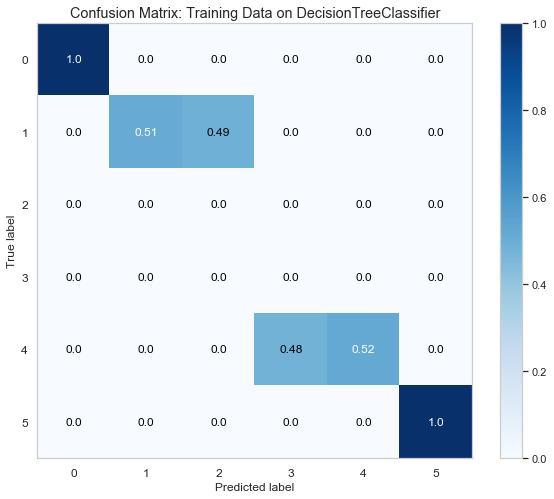

Thresholds didn't add up to 100%! This may cause issues in your results!


/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1,2,3,4,5,accuracy,macro avg,weighted avg
f1-score,1.0,0.679245,0.0,0.0,0.687023,1.0,0.68785,0.561045,0.581241
precision,1.0,0.514286,0.0,0.0,0.523256,1.0,0.68785,0.506257,0.525942
recall,1.0,1.000000,0.0,0.0,1.000000,1.0,0.68785,0.666667,0.687850
support,99.0,90.000000,85.0,82.0,90.000000,89.0,0.68785,535.000000,535.000000


Thresholds didn't add up to 100%! This may cause issues in your results!


**********Generating graphs for model's correctly predicted...**********

Generating graph for Survived.
--------------------------------------------------------------------------------


Generating graph for Pclass.
--------------------------------------------------------------------------------


Generating graph for Sex.
--------------------------------------------------------------------------------


Generating graph for Age.
--------------------------------------------------------------------------------


Generating graph for SibSp.
--------------------------------------------------------------------------------


Generating graph for Parch.
--------------------------------------------------------------------------------


Generating graph for Fare.
--------------------------------------------------------------------------------


Generating graph for Cabin.
-----------------------------------------------

,Metric Scores
Precision(micro),0.5047
Precision(macro),0.3023
Precision(weighted),0.3142
MCC,0.4723
Recall(micro),0.5047
Recall(macro),0.5000
Recall(weighted),0.5047
F1-Score(micro),0.5047
F1-Score(macro),0.3583
F1-Score(weighted),0.3679


Thresholds didn't add up to 100%! This may cause issues in your results!


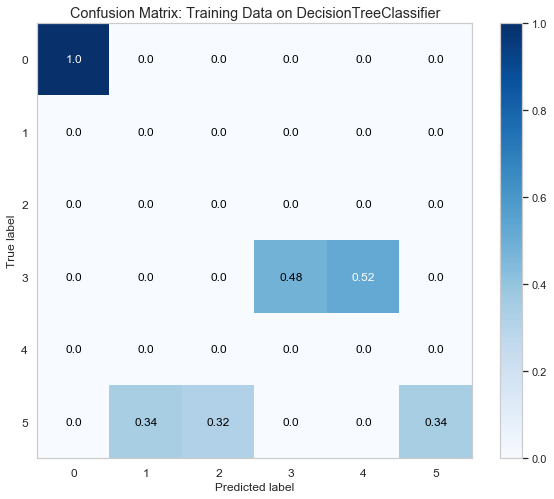

Thresholds didn't add up to 100%! This may cause issues in your results!


/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1,2,3,4,5,accuracy,macro avg,weighted avg
f1-score,1.0,0.0,0.0,0.645669,0.0,0.504249,0.504673,0.358320,0.367894
precision,1.0,0.0,0.0,0.476744,0.0,0.337121,0.504673,0.302311,0.314200
recall,1.0,0.0,0.0,1.000000,0.0,1.000000,0.504673,0.500000,0.504673
support,99.0,90.0,85.0,82.000000,90.0,89.000000,0.504673,535.000000,535.000000


Thresholds didn't add up to 100%! This may cause issues in your results!


**********Generating graphs for model's correctly predicted...**********

Generating graph for Survived.
--------------------------------------------------------------------------------


Generating graph for Pclass.
--------------------------------------------------------------------------------


Generating graph for Sex.
--------------------------------------------------------------------------------


Generating graph for Age.
--------------------------------------------------------------------------------


Generating graph for SibSp.
--------------------------------------------------------------------------------


Generating graph for Parch.
--------------------------------------------------------------------------------


Generating graph for Fare.
--------------------------------------------------------------------------------


Generating graph for Cabin.
-----------------------------------------------

,Metric Scores
Precision(micro),0.5047
Precision(macro),0.3023
Precision(weighted),0.3142
MCC,0.4723
Recall(micro),0.5047
Recall(macro),0.5000
Recall(weighted),0.5047
F1-Score(micro),0.5047
F1-Score(macro),0.3583
F1-Score(weighted),0.3679


Thresholds didn't add up to 100%! This may cause issues in your results!


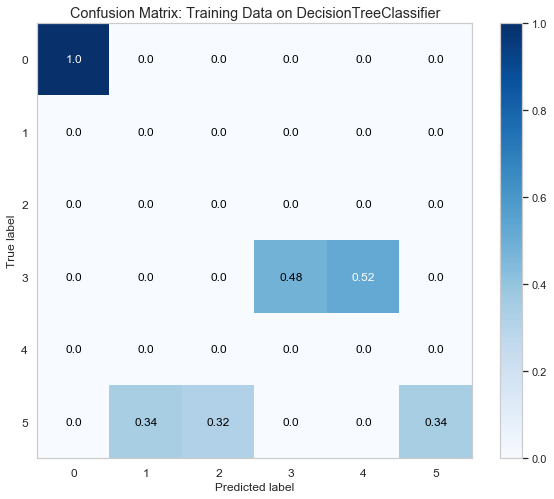

Thresholds didn't add up to 100%! This may cause issues in your results!


/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1,2,3,4,5,accuracy,macro avg,weighted avg
f1-score,1.0,0.0,0.0,0.645669,0.0,0.504249,0.504673,0.358320,0.367894
precision,1.0,0.0,0.0,0.476744,0.0,0.337121,0.504673,0.302311,0.314200
recall,1.0,0.0,0.0,1.000000,0.0,1.000000,0.504673,0.500000,0.504673
support,99.0,90.0,85.0,82.000000,90.0,89.000000,0.504673,535.000000,535.000000


Thresholds didn't add up to 100%! This may cause issues in your results!


**********Generating graphs for model's correctly predicted...**********

Generating graph for Survived.
--------------------------------------------------------------------------------


Generating graph for Pclass.
--------------------------------------------------------------------------------


Generating graph for Sex.
--------------------------------------------------------------------------------


Generating graph for Age.
--------------------------------------------------------------------------------


Generating graph for SibSp.
--------------------------------------------------------------------------------


Generating graph for Parch.
--------------------------------------------------------------------------------


Generating graph for Fare.
--------------------------------------------------------------------------------


Generating graph for Cabin.
-----------------------------------------------

,Metric Scores
Precision(micro),0.6879
Precision(macro),0.5063
Precision(weighted),0.5259
MCC,0.6639
Recall(micro),0.6879
Recall(macro),0.6667
Recall(weighted),0.6879
F1-Score(micro),0.6879
F1-Score(macro),0.5610
F1-Score(weighted),0.5812


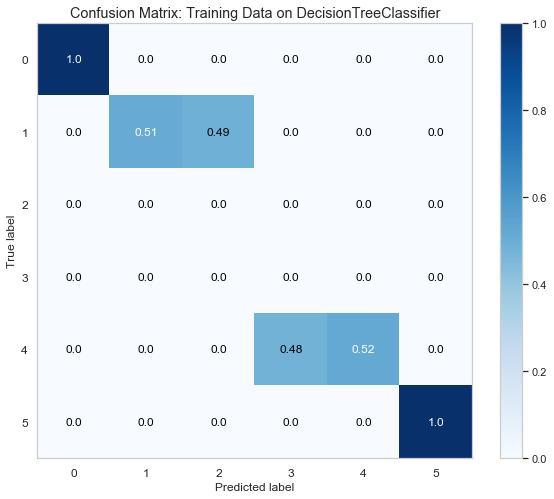

/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1,2,3,4,5,accuracy,macro avg,weighted avg
f1-score,1.0,0.679245,0.0,0.0,0.687023,1.0,0.68785,0.561045,0.581241
precision,1.0,0.514286,0.0,0.0,0.523256,1.0,0.68785,0.506257,0.525942
recall,1.0,1.000000,0.0,0.0,1.000000,1.0,0.68785,0.666667,0.687850
support,99.0,90.000000,85.0,82.0,90.000000,89.0,0.68785,535.000000,535.000000




**********Generating graphs for model's correctly predicted...**********

Generating graph for Survived.
--------------------------------------------------------------------------------


Generating graph for Pclass.
--------------------------------------------------------------------------------


Generating graph for Sex.
--------------------------------------------------------------------------------


Generating graph for Age.
--------------------------------------------------------------------------------


Generating graph for SibSp.
--------------------------------------------------------------------------------


Generating graph for Parch.
--------------------------------------------------------------------------------


Generating graph for Fare.
--------------------------------------------------------------------------------


Generating graph for Cabin.
--------------------------------------------------------------------------------




**********Generating graphs for mod

,Metric Scores
Precision(micro),0.6879
Precision(macro),0.5063
Precision(weighted),0.5259
MCC,0.6639
Recall(micro),0.6879
Recall(macro),0.6667
Recall(weighted),0.6879
F1-Score(micro),0.6879
F1-Score(macro),0.5610
F1-Score(weighted),0.5812


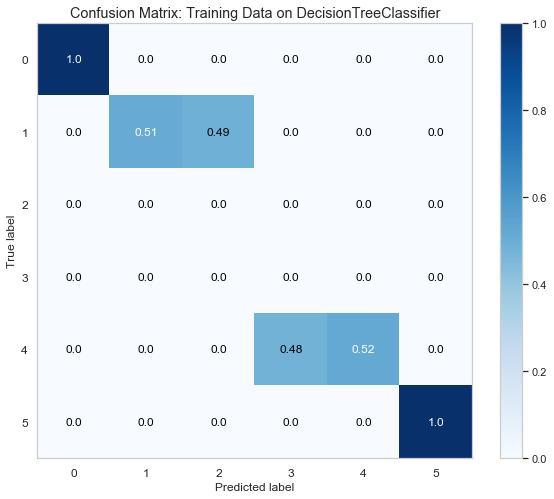

/Users/ericcacciavillani/anaconda3/envs/Master_Project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1,2,3,4,5,accuracy,macro avg,weighted avg
f1-score,1.0,0.679245,0.0,0.0,0.687023,1.0,0.68785,0.561045,0.581241
precision,1.0,0.514286,0.0,0.0,0.523256,1.0,0.68785,0.506257,0.525942
recall,1.0,1.000000,0.0,0.0,1.000000,1.0,0.68785,0.666667,0.687850
support,99.0,90.000000,85.0,82.0,90.000000,89.0,0.68785,535.000000,535.000000




**********Generating graphs for model's correctly predicted...**********

Generating graph for Survived.
--------------------------------------------------------------------------------


Generating graph for Pclass.
--------------------------------------------------------------------------------


Generating graph for Sex.
--------------------------------------------------------------------------------


Generating graph for Age.
--------------------------------------------------------------------------------


Generating graph for SibSp.
--------------------------------------------------------------------------------


Generating graph for Parch.
--------------------------------------------------------------------------------


Generating graph for Fare.
--------------------------------------------------------------------------------


Generating graph for Cabin.
--------------------------------------------------------------------------------




**********Generating graphs for mod

In [30]:
dt_analysis = ClassificationAnalysis(model=model,
                                     pred_funcs_dict={"Probabilities function":model.predict_proba,
                                                      "Predict function":model.predict},
                                     model_name=repr(model).split("(")[0],
                                     project_name=f'{parent_project_name}/Classification Analysis',
                                     notebook_mode=True,
                                     df_features=df_features)

dt_analysis.peform_analysis(X=X_train,
                            y=y_train,
                            dataset_name="Training Data",
                            thresholds_matrix=[[.2,.2,.2,.2,.2,.2],
                                               [.1,.9,.95,.15,.2,-.20],
                                               [.01,.9,.95,.15,.2,-.20]
                                             ])

In [ ]:
os.path.exists("/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlowMaster/Testing/eFlow Data/Pre processing/Supervised Analysis/DecisionTreeClassifier/Probabilities function/Thresholds")

In [ ]:
get_unique_directory_path(os.getcwd() + "/eFlow Data/Pre processing/Supervised Analysis/DecisionTreeClassifier/Test data/Probability Classification/",
                        "Model Results")

In [ ]:
error_string = os.getcwd().replace("/", "///")
error_string

In [ ]:
ab = "/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlowMaster/Testing/eFlow Data/Pre processing/Supervised Analysis/DecisionTreeClassifier/Test data/Probability Classification"
correct_directory_path(ab)

In [ ]:
a=[[1,2],[1,2,3],[1]]
c = copy.deepcopy(a)
b=np.array(a)
b.tolist()
hhh = None
if hhh:
    print("test")

In [ ]:
bbb = None

if not bbb:
    print("test")
else:
    print("fff")

In [ ]:
a == [1,2,3]